# Exploratory Analysis of Artwork Titles in the Tate Collection dataset

This notebook implements an exploratory computational pipeline to analyze the language used in artwork titles in the Tate collection in the 20th century. The goal is not to infer artistic meaning directly from titles, but to examine large-scale lexical patterns that emerge from institutional cataloguing practices over time.

The analysis focuses on word frequency distributions and their diachronic variation.



## Environment setup and imports

This section sets up the computational environment and imports the libraries required for data processing, text analysis, and visualization.

In [3]:
!pip install pandas numpy matplotlib nltk

import os
import re
from collections import Counter, defaultdict

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Helper functions

This section defines helper functions used throughout the pipeline. These include routines for normalizing year information from heterogeneous metadata fields and for cleaning textual data prior to tokenization.



In [4]:
def normalize_year(y):
    "Estrae un singolo anno valido da valori rumorosi"
    if pd.isna(y):
        return None
    if isinstance(y, (int, float)):
        y = int(y)
        if 1000 <= y <= 2100:
            return y
    s = str(y)
    m = re.search(r'(1[0-9]{3}|20[0-9]{2})', s)
    return int(m.group(1)) if m else None


def clean_text(s):
    "Normalizza il testo dei titoli"
    s = str(s).lower()
    s = re.sub(r'[^a-z\s]', ' ', s)
    return ' '.join(s.split())


## Data loading

The artwork metadata is loaded directly from the Tate Gallery’s public GitHub repository. Accessing the dataset programmatically ensures that the analysis can be rerun and verified using the same source data.

Only artwork-level metadata is considered in this project.

In [5]:
raw_artworks_url = "https://raw.githubusercontent.com/tategallery/collection/master/artwork_data.csv"
output_dir = "tate_output"
os.makedirs(output_dir, exist_ok=True)

df = pd.read_csv(
    raw_artworks_url,
    engine="python",
    sep=",",
    on_bad_lines="skip"
)

## Title filtering and cleaning

This step removes records with missing or non-informative titles. In particular, editorial placeholders such as `[title not known]` and generic labels like `Untitled` are excluded, as they reflect cataloguing conventions rather than meaningful naming practices.

Titles are then normalized by lowercasing and removing punctuation to facilitate lexical analysis.

In [12]:
df = df[df["title"].notna()].copy()

df["title_lower"] = df["title"].str.lower()

df = df[~df["title_lower"].str.contains("untitled", na=False)]

df = df[~df["title_lower"].str.contains("title not known", na=False)]

## Temporal normalization

Artwork dates in the dataset are provided in both structured and unstructured formats. This step extracts a single numeric year where possible and excludes records that cannot be reliably dated.

The analysis is limited to works produced from 1900 onwards to focus on modern and contemporary collecting practices.

In [7]:
df["year_parsed"] = df["year"].apply(normalize_year)
df = df[df["year_parsed"].notna()]
df = df[df["year_parsed"] >= 1900]

## Tokenization and basic NLP processing

Artwork titles are tokenized into individual words using standard NLP tools. English stopwords are removed to reduce the influence of highly frequent but semantically weak terms.

No lemmatization or sentiment analysis is applied, as preliminary exploration showed that such methods are poorly suited to the short and highly descriptive nature of artwork titles.

In [8]:
stop_words = set(stopwords.words("english"))

df["clean_title"] = df["title"].apply(clean_text)
df["tokens"] = df["clean_title"].apply(
    lambda x: [w for w in word_tokenize(x) if w not in stop_words]
)

## Word frequency analysis

This section computes global word frequencies across all artwork titles. The resulting distribution is visualized to assess whether the vocabulary follows a long-tail pattern.

Rather than focusing on individual words, this step provides a structural overview of how language is distributed in the dataset.

In [9]:

all_tokens = [w for tokens in df["tokens"] for w in tokens]
freq = Counter(all_tokens)

freq_df = pd.DataFrame(freq.most_common(), columns=["word", "count"])
freq_df.to_csv(f"{output_dir}/global_word_frequencies.csv", index=False)

## Long-tail distribution

The long-tail visualization highlights the imbalance between a small number of highly frequent descriptive terms and a large number of rare words.

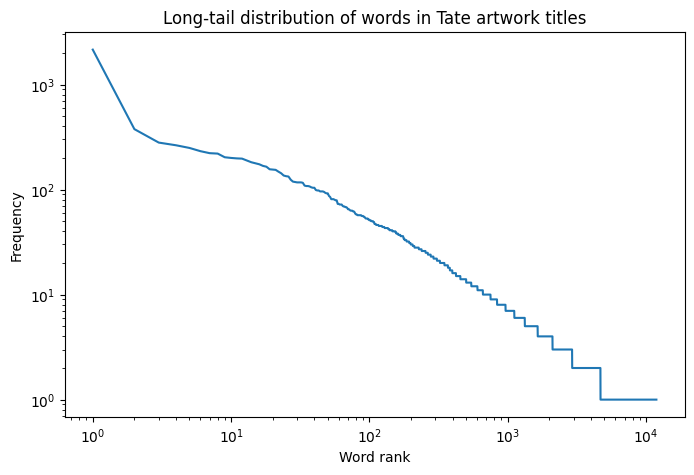

In [10]:
plt.figure(figsize=(8, 5))
plt.loglog(range(1, len(freq_df) + 1), freq_df["count"])
plt.xlabel("Word rank")
plt.ylabel("Frequency")
plt.title("Long-tail distribution of words in Tate artwork titles")
plt.show()

## Diachronic analysis by decade

To explore changes over time, artworks are grouped by decade based on their production year. Word frequencies are then calculated separately for each decade.

In [11]:
df["decade"] = (df["year_parsed"] // 10) * 10

decade_counter = defaultdict(Counter)
for _, row in df.iterrows():
    decade_counter[row["decade"]].update(row["tokens"])

rows = []
for decade, counter in decade_counter.items():
    for word, count in counter.most_common(40):
        rows.append({
            "decade": decade,
            "word": word,
            "count": count
        })

decade_df = pd.DataFrame(rows)
decade_df.to_csv(f"{output_dir}/top_words_by_decade.csv", index=False)

print("Files saved in folder:", output_dir)

Files saved in folder: tate_output
